# Exploratory data analysis

In [75]:
import pandas as pd
import numpy as np
from os.path import join
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

## Read the data

In [76]:
src = "../data"
dst = "../plots"
fname = "mapOSR_data_V5_9_2_220405_coded"
data = pd.read_csv(join(src, fname + "_clean.csv"))

In [77]:
data['Action'] = data['Action'].apply(lambda x: eval(x) if x == x else np.nan)
data['Method'] = data['Method'].apply(lambda x: eval(x) if x == x else np.nan)
data['Discipline'] = data['Discipline'].apply(lambda x: eval(x) if x == x else np.nan)
data['Group'] = data['Group'].apply(lambda x: eval(x) if x == x else np.nan)
data['Geo'] = data['Geo'].apply(lambda x: eval(x) if x == x else np.nan)

## Actions over years

In [78]:
disambiguated_action = pd.DataFrame()
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['Action'] != row['Action']: # NaN check
        continue
    if len(row['Action']) == 1:
        disambiguated_action = disambiguated_action.append(
            {'Action':row['Action'][0],
             'year':int(row['Publication Year']),
             #'N':
             'ID':row['ID']}, ignore_index=True)
    elif len(row['Action']) > 1:
        for action in row['Action']:
            disambiguated_action = disambiguated_action.append(
                {'Action':action,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        print('found one!')

In [79]:
actions = disambiguated_action\
    .groupby(by=['Action', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for action in disambiguated_action['Action'].unique():
    for year in range(2001, 2022):
        if not actions.index.isin([(action, year)]).any():
            actions.loc[(action, year), :] = 0
            
actions = actions.reset_index()
actions['year'] = actions['year'].astype(int)
actions = actions.sort_values(by=['Action', 'year'], ascending=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


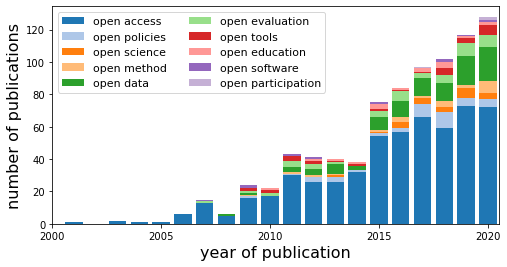

In [80]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, action in enumerate(disambiguated_action['Action'].unique()):
    tmp = actions[actions['Action'] == action]
    label = 'open {}'.format(action.split('open')[1])
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=label,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'actions_over_years.pdf'))
plt.savefig(join(dst, 'actions_over_years.svg'))
plt.savefig(join(dst, 'actions_over_years.eps'))
plt.savefig(join(dst, 'actions_over_years.png'), dpi=300)

## Methods over years

In [81]:
disambiguated_method = pd.DataFrame()
no_method = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['Method'] != row['Method']: # NaN check
        continue
    if len(row['Method']) == 1:
        disambiguated_method = disambiguated_method.append(
            {'Method':row['Method'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['Method']) > 1:
        for method in row['Method']:
            disambiguated_method = disambiguated_method.append(
                {'Method':method,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_method = disambiguated_method.append(
            {'Method':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_method += 1
print('{} entries without specified method'.format(no_method))

0 entries without specified method


In [82]:
methods = disambiguated_method\
    .groupby(by=['Method', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for method in disambiguated_method['Method'].unique():
    for year in range(2001, 2022):
        if not methods.index.isin([(method, year)]).any():
            methods.loc[(method, year), :] = 0
            
methods = methods.reset_index()
methods['year'] = methods['year'].astype(int)
methods = methods.sort_values(by=['Method', 'year'], ascending=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


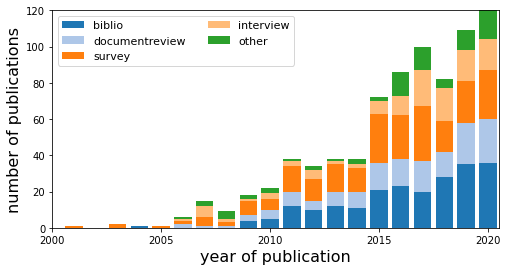

In [83]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, method in enumerate(disambiguated_method['Method'].unique()):
    tmp = methods[methods['Method'] == method]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=method,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 120)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'methods_over_years.pdf'))
plt.savefig(join(dst, 'methods_over_years.svg'))
plt.savefig(join(dst, 'methods_over_years.eps'))
plt.savefig(join(dst, 'methods_over_years.png'), dpi=300)

## Disciplines over years

In [84]:
disambiguated_discipline = pd.DataFrame()
no_discipline = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['Discipline'] != row['Discipline']: # NaN check
        continue
    if len(row['Discipline']) == 1:
        disambiguated_discipline = disambiguated_discipline.append(
            {'Discipline':row['Discipline'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['Discipline']) > 1:
        for discipline in row['Discipline']:
            disambiguated_discipline = disambiguated_discipline.append(
                {'Discipline':discipline,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_discipline = disambiguated_discipline.append(
            {'Discipline':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_discipline += 1
print('{} entries without specified discipline'.format(no_discipline))

0 entries without specified discipline


In [85]:
disciplines = disambiguated_discipline\
    .groupby(by=['Discipline', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for discipline in disambiguated_discipline['Discipline'].unique():
    for year in range(2001, 2022):
        if not disciplines.index.isin([(discipline, year)]).any():
            disciplines.loc[(discipline, year), :] = 0
            
disciplines = disciplines.reset_index()
disciplines['year'] = disciplines['year'].astype(int)
disciplines = disciplines.sort_values(by=['Discipline', 'year'], ascending=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


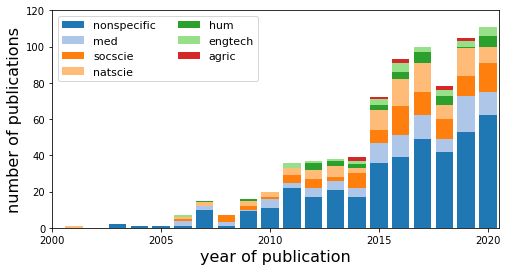

In [86]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, discipline in enumerate(disambiguated_discipline['Discipline'].unique()):
    tmp = disciplines[disciplines['Discipline'] == discipline]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=discipline,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 120)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'disciplines_over_years.pdf'))
plt.savefig(join(dst, 'disciplines_over_years.svg'))
plt.savefig(join(dst, 'disciplines_over_years.eps'))
plt.savefig(join(dst, 'disciplines_over_years.png'), dpi=300)

## Groups over years

In [87]:
disambiguated_group = pd.DataFrame()
no_group = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['Group'] != row['Group']: # NaN check
        continue
    if len(row['Group']) == 1:
        disambiguated_group = disambiguated_group.append(
            {'Group':row['Group'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['Group']) > 1:
        for group in row['Group']:
            disambiguated_group = disambiguated_group.append(
                {'Group':group,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_group = disambiguated_group.append(
            {'Group':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_group += 1
print('{} entries without specified group'.format(no_group))

0 entries without specified group


In [88]:
groups = disambiguated_group\
    .groupby(by=['Group', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for group in disambiguated_group['Group'].unique():
    for year in range(2001, 2022):
        if not groups.index.isin([(group, year)]).any():
            groups.loc[(group, year), :] = 0
            
groups = groups.reset_index()
groups['year'] = groups['year'].astype(int)
groups = groups.sort_values(by=['Group', 'year'], ascending=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


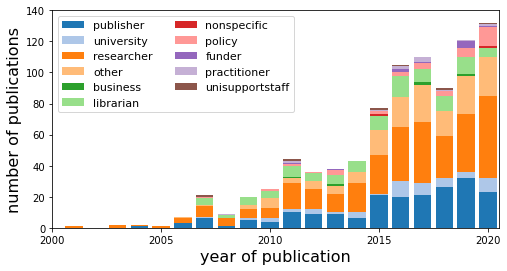

In [89]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, group in enumerate(disambiguated_group['Group'].unique()):
    tmp = groups[groups['Group'] == group]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=group,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'groups_over_years.pdf'))
plt.savefig(join(dst, 'groups_over_years.svg'))
plt.savefig(join(dst, 'groups_over_years.eps'))
plt.savefig(join(dst, 'groups_over_years.png'), dpi=300)

## Geo over years

In [90]:
disambiguated_geo = pd.DataFrame()
no_geo = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['Geo'] != row['Geo']: # NaN check
        continue
    if len(row['Geo']) == 1:
        disambiguated_geo = disambiguated_geo.append(
            {'Geo':row['Geo'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['Geo']) > 1:
        for geo in row['Geo']:
            disambiguated_geo = disambiguated_geo.append(
                {'Geo':geo,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_geo = disambiguated_geo.append(
            {'Geo':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_geo += 1
print('{} entries without specified geo'.format(no_geo))

1 entries without specified geo


In [91]:
geos = disambiguated_geo\
    .groupby(by=['Geo', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for geo in disambiguated_geo['Geo'].unique():
    for year in range(2001, 2022):
        if not geos.index.isin([(geo, year)]).any():
            geos.loc[(geo, year), :] = 0
            
geos = geos.reset_index()
geos['year'] = geos['year'].astype(int)
geos = geos.sort_values(by=['Geo', 'year'], ascending=True)

In [92]:
disambiguated_geo['Geo'].value_counts()[0:15]

nonspecific    277
USA             78
GBR             48
ESP             37
DEU             36
IND             34
CAN             25
CHN             22
FRA             22
ITA             21
AUS             18
NGA             16
AUT             14
KOR             14
EU              13
Name: Geo, dtype: int64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


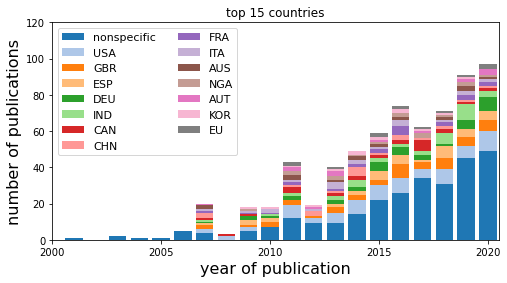

In [93]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, geo in enumerate(disambiguated_geo['Geo'].value_counts()[0:15].index):
    tmp = geos[geos['Geo'] == geo]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=geo,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 120)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
ax.set_title('top 15 countries')
plt.savefig(join(dst, 'geos_over_years.pdf'))
plt.savefig(join(dst, 'geos_over_years.svg'))
plt.savefig(join(dst, 'geos_over_years.eps'))
plt.savefig(join(dst, 'geos_over_years.png'), dpi=300)

## Compilation plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


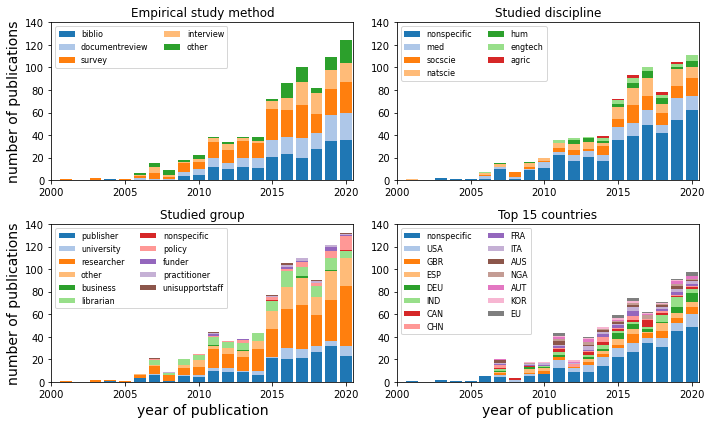

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
ax = axes[0, 0]
bottom = np.zeros(len(data['Publication Year'].unique()))
#for i, action in enumerate(disambiguated_action['Action'].unique()):
#    tmp = actions[actions['Action'] == action]
#    label = 'open {}'.format(action.split('open')[1])
#    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=label,
#           color=cmap(i))
#    bottom += tmp['count'].values
 
for i, method in enumerate(disambiguated_method['Method'].unique()):
    tmp = methods[methods['Method'] == method]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=method,
           color=cmap(i))
    bottom += tmp['count'].values
     
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=14)
#ax.set_xlabel('year of publication', fontsize=16)
ax.set_title('Empirical study method')

ax = axes[0, 1]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, discipline in enumerate(disambiguated_discipline['Discipline'].unique()):
    tmp = disciplines[disciplines['Discipline'] == discipline]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=discipline,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
#ax.set_ylabel('number of publications', fontsize=16)
#ax.set_xlabel('year of publication', fontsize=16)
ax.set_title('Studied discipline')

ax = axes[1, 0]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, group in enumerate(disambiguated_group['Group'].unique()):
    tmp = groups[groups['Group'] == group]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=group,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=14)
ax.set_xlabel('year of publication', fontsize=14)
ax.set_title('Studied group')

ax = axes[1, 1]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, geo in enumerate(disambiguated_geo['Geo'].value_counts()[0:15].index):
    tmp = geos[geos['Geo'] == geo]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=geo,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
#ax.set_ylabel('number of publications', fontsize=14)
ax.set_xlabel('year of publication', fontsize=14)
ax.set_title('Top 15 countries')

fig.tight_layout()
plt.savefig(join(dst, 'categories.png'), dpi=300)
plt.savefig(join(dst, 'categories.svg'), dpi=300)
plt.savefig(join(dst, 'categories.eps'), dpi=300)

## Geos on a map

In [95]:
import geopandas

In [96]:
geos = []

for geo in data["Geo"]:
    for g in geo:
        if len(g) == 3:
            geos.append(g)
geos = pd.DataFrame({"iso_a3":geos})
geos = geos.value_counts().reset_index().rename(columns={0:"count"})

In [97]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,count
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.0
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",8.0
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0.0
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",25.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",79.0
...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",3.0
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",0.0
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0.0
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",0.0


In [98]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
world = pd.merge(world, geos, left_on="iso_a3", right_on="iso_a3", how="left")
world["count"] = world["count"].fillna(0)

In [99]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,count
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.0
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",8.0
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0.0
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",25.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",79.0
...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",3.0
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",0.0
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0.0
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",0.0


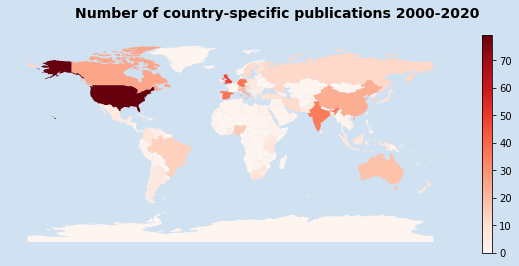

In [100]:
fig, ax = plt.subplots(figsize = (10,4), facecolor = plt.cm.Blues(.2))
fig.suptitle('Number of country-specific publications 2000-2020',
             fontsize = 14,
             fontweight="bold")
ax.set_facecolor(plt.cm.Blues(.2))
world.plot(column = 'count',
           cmap = 'Reds',
           ax = ax,
           legend = True)
ax.axis("off")
plt.savefig(join(dst, 'countries_on_map.eps'), dpi=300)
plt.savefig(join(dst, 'countries_on_map.png'), dpi=300)

## Wordcloud from article titles

In [101]:
text = ''
for title in data['Article Title']:
    text += ' '
    text += title
    
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
wc = WordCloud(background_color="white", colormap=plt.get_cmap('inferno'))
wordcloud = wc.generate(text)

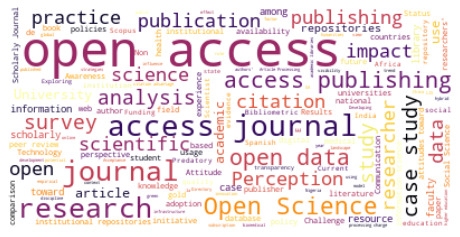

In [102]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis('off')
plt.savefig(join(dst, 'title_text_wordcloud.png'), dpi=300)

## Citations over publication year

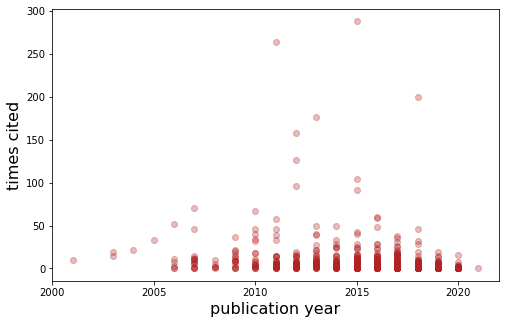

In [103]:
fig, ax = plt.subplots(figsize=(8, 5))
cols = ['Publication Year', 'Times Cited, All Databases']
tmp = data[cols].dropna(subset=cols).copy()
tmp = tmp.astype(int)
ax.scatter(tmp['Publication Year'], tmp['Times Cited, All Databases'],
           color='FireBrick', alpha=0.3)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('times cited', fontsize=16)
ax.set_xlabel('publication year', fontsize=16)
plt.savefig(join(dst, 'times_cited_over_publication_year.pdf'))